In [ ]:
! pip uninstall  opencv-python

In [12]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
aiofiles                     22.1.0
aiosqlite                    0.18.0
albumentations               1.3.1
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
brotlipy                     0.7.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
chardet                      5.2.0
charset-normalizer           2.0.4
colorama                     0.4.6
coloredlogs                  15.0.1
comm                         0.1.2
contourpy                    1.1.0
cryptography                 41.0.2
cycler                       0.11.0

In [3]:
import os
import time
import uuid
import cv2

In [3]:
IMAGE_PATH = os.path.join("data", "images")
IMAGES_NUMBER = 40

In [ ]:
#taking image samples 
cap = cv2.VideoCapture(0)

for imgnum in range(IMAGES_NUMBER):
    ret, frame = cap.read()
    print(f"capturing img {imgnum}")
    image_name = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(image_name, frame)
    cv2.imshow("frame", frame)
    time.sleep(1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [8]:
# create a TensorFlow dataset containing the paths to all .jpg files in the data\\images\\ directory, without shuffling their order.
images = tf.data.Dataset.list_files("data\\images\\*.jpg", shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

In [16]:
# Define a function to load an image from a file path.
# This function takes a string 'x' which represents the path to a JPEG image file.
def load_image(x):
    # Read the image file as a byte string.
    byte_img = tf.io.read_file(x)
    # Decode the byte string to get the actual image data in a tensor format.
    img = tf.io.decode_jpeg(byte_img)
    # Return the decoded image tensor.
    return img

# Use the 'map' function to apply 'load_image' to each element of the 'images' dataset.
# This will load all images into memory, converting their file paths to actual image data.
# images = images.map(load_image)


In [11]:
# Create batches of 4 images and transform the dataset to a NumPy iterator.
# This allows you to loop through the dataset and obtain batches as NumPy arrays.
image_generator = images.batch(4).as_numpy_iterator()


In [ ]:
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize= (10,10))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)
plt.show()

## Move the Matching Labels

In [13]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [14]:
# Import the 'albumentations' library for image augmentation.
import albumentations as alb

# Define an image augmentation pipeline using 'alb.Compose'.
# This pipeline includes various augmentation techniques like RandomCrop, HorizontalFlip, etc.
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),          # Randomly crop the image to 450x450 pixels.
    alb.HorizontalFlip(p=0.5),                      # Flip the image horizontally with a 50% chance.
    alb.RandomBrightnessContrast(p=0.2),            # Apply random brightness and contrast adjustments with a 20% chance.
    alb.RandomGamma(p=0.2),                         # Apply a random gamma correction with a 20% chance.
    alb.RGBShift(p=0.2),                            # Randomly shift the RGB channels of the image with a 20% chance.
    alb.VerticalFlip(p=0.5)                         # Flip the image vertically with a 50% chance.
], 
bbox_params=alb.BboxParams(format='albumentations',  # Specify the bounding box format.
                           label_fields=['class_labels'])  # Specify the label fields for bounding boxes.
)


###  Load a Test Image and Annotation with OpenCV and JSON

In [68]:
img = cv2.imread(os.path.join('data','train', 'images','0f2c31e2-40fe-11ee-90e5-283a4d5c1f6a.jpg'))
with open(os.path.join('data', 'train', 'labels', '0f2c31e2-40fe-11ee-90e5-283a4d5c1f6a.json'), 'r') as f:
    label = json.load(f)


In [20]:
label['shapes'][0]['points']

[[287.02127659574467, 128.82978723404258],
 [155.63829787234044, 295.3191489361702]]

In [21]:
coords = [0,0,0,0]
coords[2] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[0] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.24318484042553196,
 0.26839539007092206,
 0.448470744680851,
 0.6152482269503546]

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented

In [ ]:
# Draw a rectangle around the bounding box in the augmented image using OpenCV's 'rectangle' function.
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),  # Top-left corner coordinates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),  # Bottom-right corner coordinates
              (255,0,0),  # Rectangle color (Red)
              2)  # Rectangle line thickness
plt.imshow(augmented['image'])

## Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            print(label_path, ' exists')
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[2] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[0] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                # Open a JSON file in write mode to save annotation data.
                # The file is located in a directory structure defined by 'aug_data', the partition (train, val, test), and 'labels'.
                # The filename is generated based on the image name and a variable 'x'.
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)  # Save the 'annotation' dictionary to the JSON file.


        except Exception as e:
            print(e)

In [17]:
# List all the JPEG files in the 'aug_data/train/images' directory and create a TensorFlow dataset.
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
# Map the 'load_image' function onto the dataset to read the actual image files.
train_images = train_images.map(load_image)
# Resize all images in the dataset to 120x120 pixels.
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
# Normalize the pixel values of all images to fall in the range [0, 1].
train_images = train_images.map(lambda x: x/255)

# same thing for test and validation
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [70]:
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

In [ ]:
# Create an iterator to extract images
train_images_iter = iter(train_images)

# Extract the first 5 images
num_images_to_plot = 5
images_to_plot = []
for _ in range(num_images_to_plot):
    image = next(train_images_iter)
    images_to_plot.append(image)

# Plot the images
plt.figure(figsize=(10,8))
for i, image in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [19]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [20]:
# List all JSON files in the 'aug_data/train/labels' directory and create a TensorFlow dataset.
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
# Map the 'load_labels' function onto the dataset to read the actual JSON label files.
# Use tf.py_function to call a custom Python function ('load_labels') that returns tensors of type tf.uint8 and tf.float16.
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5757, 0.2396, 0.8677, 0.6094], dtype=float16))

## Combine Label and Image Samples

In [33]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(3600, 3600, 780, 780, 840, 840)

In [22]:
# Zip the train_images and train_labels datasets into a single dataset.
train = tf.data.Dataset.zip((train_images, train_labels))
# Shuffle the dataset with a buffer size of 5000.
train = train.shuffle(5000)
# Batch the dataset into groups of 8.
train = train.batch(8)
# Prefetch up to 4 batches to improve performance.
train = train.prefetch(4)


test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [24]:
t = train.as_numpy_iterator()

In [28]:
t.next()[0].shape , t.next()[1]

((8, 120, 120, 3),
 (array([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]], dtype=uint8),
  array([[0.794 , 0.274 , 1.    , 0.687 ],
         [0.9536, 0.879 , 1.    , 1.    ],
         [0.4993, 0.3945, 0.738 , 0.789 ],
         [0.3176, 0.509 , 0.535 , 0.8115],
         [0.6206, 0.0713, 0.9834, 0.5015],
         [0.2203, 0.3186, 0.4731, 0.647 ],
         [0.2654, 0.4294, 0.5015, 0.79  ],
         [0.7007, 0.1155, 0.878 , 0.3555]], dtype=float16)))

## View Images and Annotations

In [30]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 1)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [11]:
vgg = VGG16(include_top=False)

In [12]:
vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
#  Build instance of Network8.3 Build instance of Network

def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [32]:
facetracker = build_model()

In [33]:
facetracker.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [34]:
X, y = train.as_numpy_iterator().next()


In [35]:
X.shape

(8, 120, 120, 3)

In [36]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 17s 17s/step


In [77]:
classes, coords

(array([[0.4560641 ],
        [0.37597677],
        [0.4017129 ],
        [0.45918056],
        [0.5004165 ],
        [0.400116  ],
        [0.4852648 ],
        [0.40306374]], dtype=float32),
 array([[0.5032576 , 0.7608045 , 0.58193827, 0.59222084],
        [0.4941104 , 0.7221111 , 0.5762483 , 0.6014191 ],
        [0.55755156, 0.83101493, 0.5525288 , 0.590166  ],
        [0.5091583 , 0.7462693 , 0.61054486, 0.50884086],
        [0.5754683 , 0.782101  , 0.5023267 , 0.49650928],
        [0.48127925, 0.6946944 , 0.48473877, 0.50310904],
        [0.53417987, 0.77402174, 0.51651824, 0.5841782 ],
        [0.5227078 , 0.7194785 , 0.53455836, 0.6235903 ]], dtype=float32))

In [43]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [37]:
# Calculate the number of batches per epoch based on the length (size) of the training dataset
batches_per_epoch = len(train)

# Calculate the learning rate decay factor
# The formula (1./0.75 -1) is a specific choice and 'batches_per_epoch' scales the decay by the number of batches
lr_decay = (1./0.75 -1) / batches_per_epoch  # Here, 0.75 could be a target learning rate fraction for decay

# Initialize the Adam optimizer with an initial learning rate of 0.0001 and decay factor calculated above
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


In [38]:
lr_decay

0.0007407407407407406

In [39]:
# Create Localization Loss and Classification Loss

def localization_loss(y_true, yhat):  
    # Calculate the squared differences between the true and predicted x and y coordinates
    # y_true[:,:2] selects the first two columns which are x and y coordinates for the ground truth
    # yhat[:,:2] does the same for the predicted values
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # Compute the height and width for the ground truth bounding boxes
    # y_true[:,3] - y_true[:,1] calculates the height difference (y_max - y_min)
    # y_true[:,2] - y_true[:,0] calculates the width difference (x_max - x_min)
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    # Compute the height and width for the predicted bounding boxes
    # Similar to ground truth but using predicted values
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 

    # Calculate the squared differences between the true and predicted heights and widths
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    # The final loss is the sum of coordinate and size losses
    return delta_coord + delta_size


classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [84]:
y[1]

array([[0.     , 0.1978 , 0.2847 , 0.543  ],
       [0.637  , 0.2556 , 0.98   , 0.6587 ],
       [0.3704 , 0.3557 , 0.662  , 0.694  ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.2693 , 0.2125 , 0.5303 , 0.534  ],
       [0.07697, 0.91   , 0.2932 , 1.     ],
       [0.2947 , 0.3027 , 0.543  , 0.623  ],
       [0.     , 0.612  , 0.08026, 0.9995 ]], dtype=float16)

In [82]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.391046>

In [83]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.816259>

 ## Create Custom Model Class

In [40]:
# Import the Model class from TensorFlow to extend it
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the custom model FaceTracker by extending the Model class
class FaceTracker(Model): 

    # Initialization
    def __init__(self, faceDetection,  **kwargs): 
        # Call the parent constructor
        super().__init__(**kwargs)
        # Store the face detection model
        self.model = faceDetection

    # Compile the model with required optimizer and loss functions
    def compile(self, opt, classloss, localizationloss, **kwargs):
        # Call parent compile, allows extending the functionality later if needed
        super().compile(**kwargs)
        # Store classification loss function
        self.closs = classloss
        # Store localization loss function
        self.lloss = localizationloss
        # Store the optimizer
        self.opt = opt
    
    # Define one training step
    def train_step(self, batch, **kwargs): 
        
        # Unpack the batch data
        X, y = batch

        # Record operations for which gradients have to be calculated
        with tf.GradientTape() as tape: 
            # Get predictions for class and bounding box coordinates
            classes, coords = self.model(X, training=True)
            
            # Compute classification loss for the batch
            batch_classloss = self.closs(y[0], classes)
            # Compute localization loss for the batch
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # Calculate the total loss
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            # Compute gradients for trainable variables with respect to the total loss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        # Update the weights of the model
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        # Return the computed losses for this batch
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    # Define the testing step
    def test_step(self, batch, **kwargs): 
        # Unpack the batch
        X, y = batch
        
        # Get the model predictions (not updating the model)
        classes, coords = self.model(X, training=False)
        
        # Compute classification and localization losses
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        
        # Calculate the total loss
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        # Return computed losses
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    # Define the call method
    def call(self, X, **kwargs): 
        # Forward pass through the internal face detection model
        return self.model(X, **kwargs)


In [41]:
model = FaceTracker(facetracker)

In [11]:
model.compile(opt, classloss, regressloss)


NameError: name 'model' is not defined

In [63]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

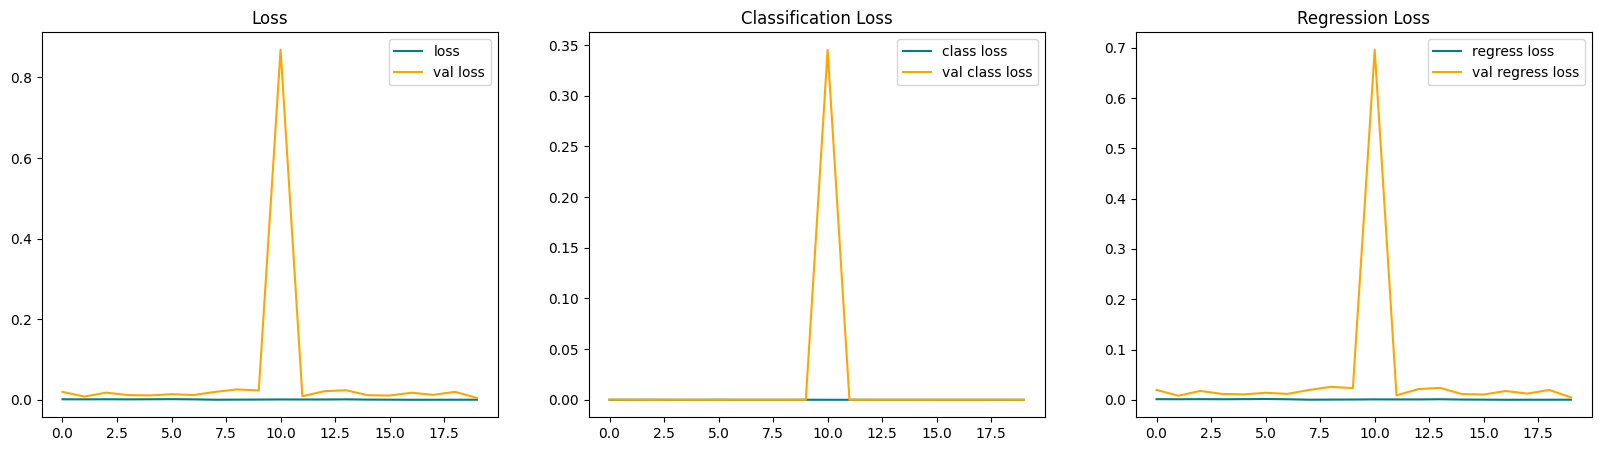

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
# 11.1 Make Predictions on Test Set


test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [10]:
#save the model
from tensorflow.keras.models import load_model
# facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [8]:
#Save  Model in SavedModel Format
facetracker.save("facemodel/1/")

INFO:tensorflow:Assets written to: facemodel/1/assets


INFO:tensorflow:Assets written to: facemodel/1/assets


In [13]:
#Create a .tar.gz Archive
!tar -czvf model.tar.gz -C facemodel .

a .
a ./1
a ./1/assets
a ./1/keras_metadata.pb
a ./1/saved_model.pb
a ./1/variables
a ./1/variables/variables.data-00000-of-00001
a ./1/variables/variables.index


In [ ]:
import tensorflow as tf

# Load the model
facetracker = tf.keras.models.load_model('model.tar.gz')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()